In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import copy,os
import pickle
from datetime import timedelta

import warnings
warnings.filterwarnings('ignore')

## Experiment part 1: End to end V.S. two-stage model (MQRNN)

In [2]:
df_sales = pd.read_csv('../data/1320/rdc_sales_1320_replenishment_V1_filled_pp.csv')
df_sl = df_sales.set_index('row')
df_sl.rename(columns=lambda x: (dt.datetime(2016,1,1) + dt.timedelta(days=int(x)-730)).date(), inplace=True)
df_sl['SKU'], df_sl['DC'] = df_sl.index.str.split('#', 1).str

In [3]:
START_DAY = dt.datetime(2018,7,27)

#Benchmark2 qunatile prediction: quantiles = [0.1, 0.25, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
with open('pred_E2E_SF_RNN.pkl', 'rb') as fp: 
    bc2_o = pickle.load(fp)

#Item_sku_id, sku_id, create_tm, complete_dt, vlt_actual, E2E_MLP_pred, E2E_NN_SF_mean_pred, E2E_NN_vlt_pred 
df_orders_o = pd.read_csv('pred_v5.csv', parse_dates=['create_tm','complete_dt','next_complete_dt'])

df_orders_o.head()

,item_sku_id,sku_id,create_tm,complete_dt,vlt_actual,initial_stock,mean_14,review_period,next_complete_dt,E2E_MLP_pred,E2E_RNN_pred,E2E_NN_SF_mean_pred,E2E_NN_vlt_pred
0,258214#3,258214,2018-08-07 16:22:00,2018-08-14 15:46:00,6.975035,2701,162.500000,5.543704,2018-08-18 14:39:00,1865.74570,1751.37660,660.26610,6.378346
1,258214#3,258214,2018-08-13 05:25:00,2018-08-18 14:39:00,5.384803,1795,149.714286,6.987188,2018-08-25 14:41:00,2180.92140,2206.21700,660.95984,6.655314
2,258214#4,258214,2018-08-06 05:15:00,2018-08-15 23:17:00,9.751354,20,24.857143,1.462674,2018-08-15 23:16:00,276.28622,328.60715,100.58999,7.750604
3,258214#4,258214,2018-08-07 16:22:00,2018-08-15 23:16:00,8.287627,9,23.000000,5.543704,2018-08-22 23:11:00,384.18080,356.58777,99.17105,7.478106
4,258214#4,258214,2018-08-13 05:25:00,2018-08-22 23:11:00,9.740532,123,23.285714,6.987188,2018-08-27 23:19:00,414.60123,396.71997,104.44367,7.099046


In [4]:
b,h=9,1

In [5]:
bc2 = bc2_o[:6000,:,:]
df_orders = df_orders_o.iloc[:6000,:]

In [6]:
o4 = df_orders.copy()

In [7]:
o4['demand_RV_list'] = o4.apply(lambda x: df_sl.loc[x['item_sku_id'], \
                                            x['create_tm'].date():x['next_complete_dt'].date()].values\
                            if x['item_sku_id'] in df_sl.index else [], axis=1)

o4['demand_RV_list_acm'] = o4['demand_RV_list'].apply(lambda x: np.cumsum(x))

In [8]:
def get_inv(x, name):
    inv1, inv2 = [], []
 
    for t in range(len(x['demand_RV_list_acm'])):
        if t < np.ceil(x['vlt_actual']):
            inv1.append(x['initial_stock']-x['demand_RV_list_acm'][t])
            continue
        else:
#             if inv[-1] <= 0:
#                 inv.append(-x['demand_RV_list'][t])
#             else:
#                 inv.append(inv[-1] - x['demand_RV_list'][t])
            inv_ = x[name]+x['initial_stock']-x['demand_RV_list_acm'][t]
            inv1.append(inv_)
            inv2.append(inv_)
    return [inv1, inv2]

def get_agginv(x, name):
    inv1, inv2 = [x['initial_stock'][0]], []
    rd = len(x['sku_id'])
 
    for r in range(rd):
        if r < rd - 1:
            len_day = len(x['demand_RV_list'][r])-1
        else:
            len_day = len(x['demand_RV_list'][r])
        for t in range(len_day):
            if t == 0:
                if r == 0:
                    replen = int(round(x[name+'_pred'][r] - inv1[0]))
                else:
                    try:
                        replen = int(round(x[name+'_pred'][r] - max(inv1[-int(round(x['vlt_actual'][r]))-1], 0)))
                    except:
                        replen = int(round(x[name+'_pred'][r] - max(inv1[1],0)))
            if t < int(round(x['vlt_actual'][r])):
                if r == 0:
                    inv1.append(inv1[-1] - x['demand_RV_list'][r][t])
            elif t == int(round(x['vlt_actual'][r])):
                if inv1[-1] >= 0:
                    inv_ = inv1[-1] + replen - x['demand_RV_list'][r][t]
                else:
                    inv_ = replen - x['demand_RV_list'][r][t]
                inv1.append(inv_)
                inv2.append(inv_)
            else:
                inv_ = inv1[-1] - x['demand_RV_list'][r][t]
                inv1.append(inv_)
                inv2.append(inv_)
    
    inv1 = inv1[1:]
    return [inv1, inv2]

In [21]:
o4['Bm1_pred'] = np.mean(bc2[:,:,4], axis=1)
o4['Bm1_pred'] = o4['Bm1_pred'] * (np.ceil(o4['review_period']) + np.ceil(o4['E2E_NN_vlt_pred']))

def get_bm2(x):
    rl = np.ceil(x['review_period']) + np.ceil(x['E2E_NN_vlt_pred'])
    if rl <= b:
        days = int(rl)
    else:
        days = int(rl) - rl//(b+h)
    return x['Bm2_pred'] * days

o4['Bm2_pred'] = np.mean(bc2[:,:,4], axis=1)
o4['Bm2_pred'] = o4.apply(get_bm2, axis=1)

o4['Bm1_replen'] = (o4['Bm1_pred'] - o4['initial_stock']).clip(0)
o4['Bm1_inv_f'], o4['Bm1_inv'] = zip(*o4.apply(get_inv, name='Bm1_replen', axis=1))
o4['Bm2_replen'] = (o4['Bm2_pred'] - o4['initial_stock']).clip(0)
o4['Bm2_inv_f'], o4['Bm2_inv'] = zip(*o4.apply(get_inv, name='Bm2_replen', axis=1))

In [22]:
o4g = o4.groupby('item_sku_id').agg(lambda x: x.tolist())
o4g['Demand_agg_list'] = o4g.apply(lambda x: df_sl.loc[x.name, \
                                            x['create_tm'][0].date():x['next_complete_dt'][-1].date()].values\
                                            , axis=1)

In [23]:
o4g['E2E_MLP_agginv_f'], o4g['E2E_MLP_agginv'] = zip(*o4g.apply(get_agginv, name='E2E_MLP',  axis=1))
o4g['E2E_RNN_agginv_f'], o4g['E2E_RNN_agginv'] = zip(*o4g.apply(get_agginv, name='E2E_RNN',  axis=1))
o4g['Bm1_agginv_f'], o4g['Bm1_agginv'] = zip(*o4g.apply(get_agginv, name='Bm1',  axis=1))
o4g['Bm2_agginv_f'], o4g['Bm2_agginv'] = zip(*o4g.apply(get_agginv, name='Bm2',  axis=1))

In [24]:
list_c2 = ['SKU_DC',
          'E2E_MLP', 'E2E_RNN',
          'Bm1','Bm2',  
          'Ave_sales'
         ]
str_list2 = ['E2E_MLP', 'E2E_RNN', 'Bm1','Bm2']

numberOfRows = len(o4g)
df2_cost_agg = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c2)
df2_holding_agg = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c2)
df2_back_agg = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c2)
df2_stockout_agg = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c2)
df2_turnover_agg = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c2)

df2_cost_agg['SKU_DC']=df2_holding_agg['SKU_DC']=df2_back_agg['SKU_DC']=df2_stockout_agg['SKU_DC']\
            =df2_turnover_agg['SKU_DC']=o4g.index.values
df2_cost_agg['Ave_sales']=df2_holding_agg['Ave_sales']=df2_back_agg['Ave_sales']=df2_stockout_agg['Ave_sales']\
            =df2_turnover_agg['Ave_sales']=o4g['mean_14'].apply(lambda x:x[0]).values

In [25]:
o4g_ = o4g.reset_index(drop=True)
for str1 in str_list2:
    str2 = str1 + '_agginv'
    df2_holding_agg[str1] = o4g_[str2].apply(lambda x: h * sum([inv for inv in x if inv>0]) )
    df2_back_agg[str1] = o4g_[str2].apply(lambda x: b * -sum([inv for inv in x if inv<0]) )
    df2_stockout_agg[str1] = o4g_[str2].apply(lambda x: len([inv for inv in x if inv<0])/len(x) if len(x)>0 else 0 )
    df2_turnover_agg[str1] = o4g_.apply(lambda x: np.mean([max(i,0) for i in x[str2]]) / x['mean_14'][0]
                                  if np.mean(x['mean_14'][0]) >0 else np.mean(x[str2]), axis=1).fillna(7)
    df2_cost_agg[str1] = df2_holding_agg[str1] + df2_back_agg[str1]

In [26]:
df2_aggcom = pd.DataFrame({'Total cost': df2_cost_agg[str_list2].mean(),
             'Holding cost': df2_holding_agg[str_list2].mean(),
             'Stockout cost': df2_back_agg[str_list2].mean(),
             'Stockout rate': df2_stockout_agg[str_list2].mean(),
             'Turnover rate': df2_turnover_agg[str_list2].mean(),
             }).T
df2_aggcom

,E2E_MLP,E2E_RNN,Bm1,Bm2
Total cost,3701.459925,3767.598876,3885.873408,3833.954682
Holding cost,2186.604869,2265.805618,2495.221723,2146.100749
Stockout cost,1514.855056,1501.793258,1390.651685,1687.853933
Stockout rate,0.106653,0.080022,0.083673,0.105084
Turnover rate,9.682777,12.120561,10.583016,9.293440


In [27]:
print(df2_aggcom.to_latex(float_format=lambda x: '%.2f' % x))

\begin{tabular}{lrrrr}
\toprule
{} &  E2E\_MLP &  E2E\_RNN &     Bm1 &     Bm2 \\
\midrule
Total cost    &  3701.46 &  3767.60 & 3885.87 & 3833.95 \\
Holding cost  &  2186.60 &  2265.81 & 2495.22 & 2146.10 \\
Stockout cost &  1514.86 &  1501.79 & 1390.65 & 1687.85 \\
Stockout rate &     0.11 &     0.08 &    0.08 &    0.11 \\
Turnover rate &     9.68 &    12.12 &   10.58 &    9.29 \\
\bottomrule
\end{tabular}



41
\begin{tabular}{lrrrr}
\toprule
{} &  E2E\_MLP &  E2E\_RNN &     Bm1 &     Bm2 \\
\midrule
Total cost    &  1663.00 &  1818.00 & 2585.00 & 2361.00 \\
Holding cost  &  1600.00 &  1818.00 & 2585.00 & 2361.00 \\
Stockout cost &    63.00 &     0.00 &    0.00 &    0.00 \\
Stockout rate &     0.04 &     0.00 &    0.00 &    0.00 \\
Turnover rate &     6.27 &     7.12 &   10.12 &    9.25 \\
\bottomrule
\end{tabular}



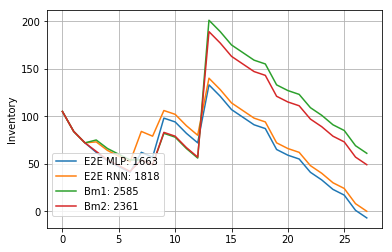

In [126]:
i=41
print(i)
tt = o4g.iloc[i,:]
fig, ax1 = plt.subplots(figsize=(6, 4))
ax1.plot(tt['E2E_MLP_agginv_f'], label = 'E2E MLP: 1663')
ax1.plot(tt['E2E_RNN_agginv_f'], label = 'E2E RNN: 1818')
ax1.plot(tt['Bm1_agginv_f'], label = 'Bm1: 2585')
ax1.plot(tt['Bm2_agginv_f'], label = 'Bm2: 2361')
ax1.legend(loc='center left', bbox_to_anchor=(0., 0.2))
ax1.grid(True)
ax1.set_ylabel('Inventory')
ax1.set_ylabel('Inventory')
plt.savefig('../figures/eps/exp1_inv.eps', dpi=200)

s_cost_agg = pd.DataFrame(index=np.arange(0, 1), columns=list_c2)
s_holding_agg = pd.DataFrame(index=np.arange(0, 1), columns=list_c2)
s_back_agg = pd.DataFrame(index=np.arange(0, 1), columns=list_c2)
s_stockout_agg = pd.DataFrame(index=np.arange(0, 1), columns=list_c2)
s_turnover_agg = pd.DataFrame(index=np.arange(0, 1), columns=list_c2)

s_cost_agg['SKU_DC']=s_holding_agg['SKU_DC']=s_back_agg['SKU_DC']=s_stockout_agg['SKU_DC']\
            =s_turnover_agg['SKU_DC']=o4g.iloc[i:i+1,:].index.values
s_cost_agg['Ave_sales']=s_holding_agg['Ave_sales']=s_back_agg['Ave_sales']=s_stockout_agg['Ave_sales']\
            =s_turnover_agg['Ave_sales']=o4g.iloc[i:i+1,:]['mean_14'].apply(lambda x:x[0]).values

for str1 in str_list2:
    str2 = str1 + '_agginv'
    s_holding_agg[str1] = o4g.iloc[i:i+1,:][str2].apply(lambda x: h * sum([inv for inv in x if inv>0]) ).values
    s_back_agg[str1] = o4g.iloc[i:i+1,:][str2].apply(lambda x: b * -sum([inv for inv in x if inv<0]) ).values
    s_stockout_agg[str1] = o4g.iloc[i:i+1,:][str2].apply(lambda x: len([inv for inv in x if inv<0])/len(x) if len(x)>0 else 0 ).values
    s_turnover_agg[str1] = o4g.iloc[i:i+1,:].apply(lambda x: np.mean([max(i,0) for i in x[str2]]) / x['mean_14'][0]
                                  if np.mean(x['mean_14'][0]) >0 else np.mean(x[str2]), axis=1).fillna(7).values
    s_cost_agg[str1] = s_holding_agg[str1] + s_back_agg[str1]
    
s_aggcom = pd.DataFrame({'Total cost': s_cost_agg[str_list2].mean(),
             'Holding cost': s_holding_agg[str_list2].mean(),
             'Stockout cost': s_back_agg[str_list2].mean(),
             'Stockout rate': s_stockout_agg[str_list2].mean(),
             'Turnover rate': s_turnover_agg[str_list2].mean(),
             }).T
print(s_aggcom.to_latex(float_format=lambda x: '%.2f' % x))


In [128]:
tt.name

'1035103#3'